# Lab 5: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"L5_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by October 31, 2018 and put **"AML-L5"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Non-negative Matrix Factorization is a model where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.

Fill in the following class that implements a NMF by multiplicative updates using the Frobenius norm or the Kullback-Leiber divergence as loss function (implement both). Try 10 different random initializations and choose the best one.

In [2]:
class my_NMF():
    
    def __init__(self, n_components, loss, epsilon, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_: float
            convergence
        loss_ = {"Frobenius", "KL"}
        W_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.loss_ = loss
        self.epsilon_ = epsilon
        self.W_ = None
        self.H_ = None
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """ 
        def dist_Frob(X, W, H):
            n = X.shape[0]
            p = X.shape[1]
            WH = W @ H
            diff = X - WH
            square = np.multiply(diff, diff)
            sum_ = square.sum()
            return(sum_)
        
        def dist_KL(X, W, H):
            WH = W @ H
            eps = np.ones((X.shape[0], X.shape[1]))*(1e-7)
            matrix = WH - X + np.multiply(X, np.log(np.divide(X, WH)+eps))
            sum_mat = matrix.sum()
            return(sum_mat)
                                             
        num_samples, num_features = X.shape
        
        #Initializing with strictly positive values 
        W = np.random.uniform(2, 3,(num_samples, self.n_components_))
        H = np.random.uniform(2, 3,(self.n_components_, num_features))
        
        
        if self.loss_ == "Frobenius":
            k = 0
            while dist_Frob(X, W, H) > self.epsilon_ and k < self.max_iter_:
                num_W = X @ H.T
                denom_W = W @ H @ H.T
                W = np.multiply(W, np.divide(num_W, denom_W))
                
                num_H = W.T @ X
                denom_H = W.T @ W @ H
                H = np.multiply(H, np.divide(num_H, denom_H))
                
                k = k + 1
                
            self.W_ = W
            self.H_ = H
        
        elif self.loss_ == "KL":
            k = 0
            H_prec = H
            W_prec = W 
            
            while dist_KL(X, W, H) > self.epsilon_ and k < self.max_iter_:
                WH = W @ H 
                
                X_sur_WH = np.divide(X, WH)
                
                # Computing W
                prod_W = X_sur_WH @ H.T
                
                one_W = np.ones((num_features, num_samples))
                S_W = (H @ one_W).T
                
                update_mat_W = np.divide(prod_W, S_W)
                
                W = np.multiply(W_prec, update_mat_W)
                
                # Computing H
                W_trans = W.T 
                prod_H = W_trans @ X_sur_WH
                
                one_H = np.ones((num_features, num_samples))
                
                S_H = (one_H @ W).T
                
                update_mat_H = np.divide(prod_H, S_H)
                
                H = np.multiply(H_prec, update_mat_H)
                        
                H_prec = H
                W_prec = W
                
                k = k + 1 
        
        else: 
            print("Unknown loss")
        
        self.W_ = W
        self.H_ = H 

**Bonus (not graded)**: Implement the regularized version

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

(400, 4096)

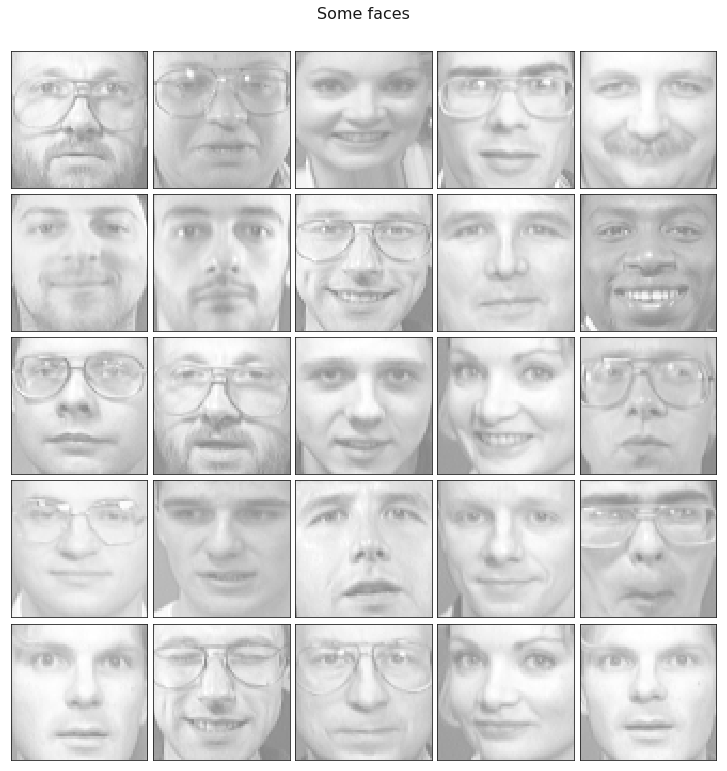

In [3]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:25], image_shape)

faces.shape

Apply your NMF algorithm for this dataset and plot the approximated face pictures.

In [4]:
Frob = my_NMF(n_components = 49, loss = "Frobenius", epsilon = 0.001, max_iter = 100)
Frob.fit_transform(faces)

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Choose one face, plot its corresponding weights (in $H$) in a grid  and explain the interpretation of the both factor matrices.

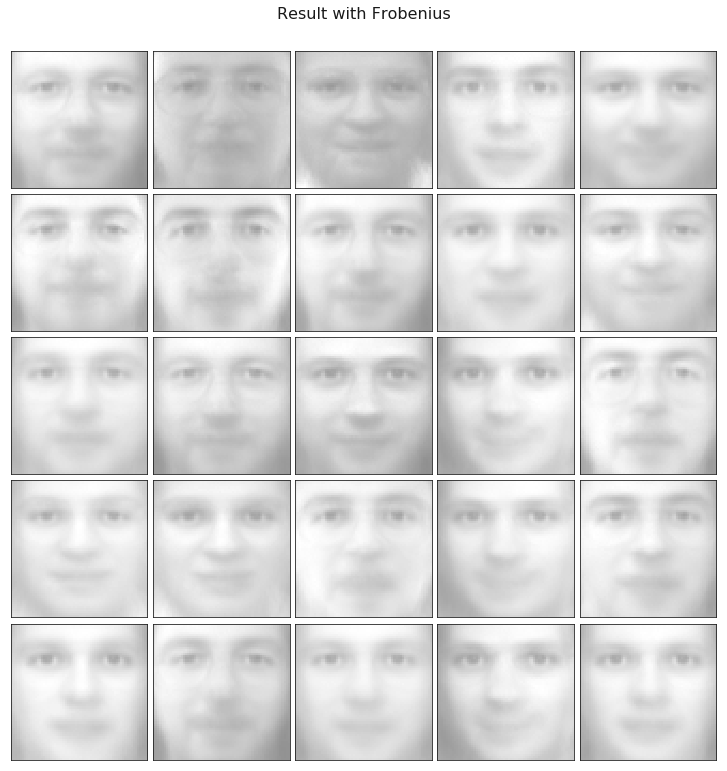

In [5]:
plot_faces("Result with Frobenius", np.dot(Frob.W_, Frob.H_)[:25], image_shape)

In [6]:
KL = my_NMF(n_components = 49, loss = "KL", epsilon = 0.001, max_iter = 100)
KL.fit_transform(faces)

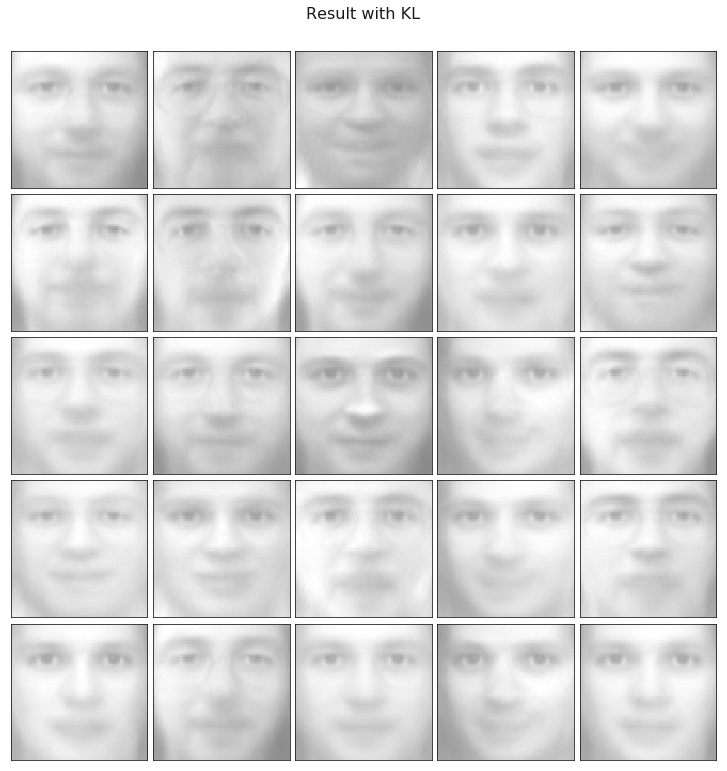

In [7]:
plot_faces("Result with KL", np.dot(KL.W_, KL.H_)[:25], image_shape)

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with NMF. Print the most common words of each topic.

In [8]:
from sklearn.datasets import fetch_20newsgroups_vectorized

In [9]:
newsgroups_train = fetch_20newsgroups_vectorized(subset='train')

In [10]:
newsgroups_train.data

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [11]:
#Computing on 300 articles
news = newsgroups_train.data.todense()
X_news = news[:300,:]
X_news.shape

(300, 130107)

In [12]:
model = my_NMF(n_components = 49, loss = "Frobenius", epsilon = 0.001, max_iter = 60)
model.fit_transform(X_news)

/Users/soufianehadji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


In [13]:
news_csr = sparse.csr_matrix(np.dot(model.W_, model.H_))